# **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

In [ ]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


# **Data**

In [ ]:
mainDIR = os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)')
print(mainDIR)

['val', 'test', 'train']


In [ ]:
train_folder= '/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train'
val_folder = '/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val'
test_folder = '/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test'

In [ ]:
from prettytable import PrettyTable
# statestics after spliting the dataset and adding noise
# stats train
num_train_normal = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train/Normal'))
num_train_bacterial = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train/Bacterial'))
num_train_viral = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train/Viral'))
TOT_train = num_train_normal + num_train_bacterial + num_train_viral
# stats test
num_test_normal = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Normal'))
num_test_bacterial = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Bacterial'))
num_test_viral = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Viral'))
TOT_test = num_test_viral + num_test_bacterial + num_test_normal
# stats valdidation
num_valid_normal = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Normal'))
num_valid_bacterial = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Bacterial'))
num_valid_viral = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Viral'))
TOT_valid = num_valid_normal + num_valid_bacterial + num_valid_viral

TOT_normal =  num_valid_normal + num_test_normal + num_train_normal
TOT_viral = num_valid_viral + num_test_viral + num_train_viral
TOT_bacterial = num_train_bacterial + num_test_bacterial + num_valid_bacterial
TOT_all = TOT_normal + TOT_viral +TOT_bacterial

#table stat general
t = PrettyTable(['Class','Train','Validation', 'Test','Total'])
t.add_row(['Normal',num_train_normal,num_valid_normal,num_test_normal,TOT_normal])
t.add_row(['viral',num_train_viral,num_valid_viral,num_test_viral,TOT_viral])
t.add_row(['Bacterial',num_train_bacterial,num_valid_bacterial,num_test_bacterial,TOT_bacterial])
t.add_row(['Total',TOT_train,TOT_valid,TOT_test,TOT_all])
print(t)

+-----------+-------+------------+------+-------+
|   Class   | Train | Validation | Test | Total |
+-----------+-------+------------+------+-------+
|   Normal  |  1614 |    118     | 120  |  1852 |
|   viral   |  3045 |    111     | 113  |  3269 |
| Bacterial |  2835 |    208     | 209  |  3252 |
|   Total   |  7494 |    437     | 442  |  8373 |
+-----------+-------+------------+------+-------+


---
Data-Frames

In [ ]:
import pandas as pd
def create_df(directory):
    file_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.jpeg'): # or any other image format
                    file_path = os.path.join(class_path, file_name)
                    file_paths.append(file_path)
                    labels.append(class_folder)
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    return df

# Create DataFrames for train, validation, and test sets
train_df = create_df(train_folder)
val_df = create_df(val_folder)
test_df = create_df(test_folder)

# Print the number of images and classes in each set
print('Train set:', len(train_df), train_df['label'].nunique())
print('Validation set:', len(val_df), val_df['label'].nunique())
print('Test set:', len(test_df), test_df['label'].nunique())

Train set: 7494 3
Validation set: 437 3
Test set: 442 3


In [ ]:
#mege train and val

frames = [train_df, val_df]

train_df = pd.concat(frames)
print('Train set:', len(train_df), train_df['label'].nunique())
print('Test set:', len(test_df), test_df['label'].nunique())

Train set: 7931 3
Test set: 442 3


In [ ]:
train_df

,file_path,label
0,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Viral
1,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Viral
2,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Viral
3,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Viral
4,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Viral
...,...,...
432,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Bacterial
433,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Bacterial
434,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Bacterial
435,/content/drive/MyDrive/chest_xray 3c [AUG + NO...,Bacterial




---
CLAHE


In [ ]:
def claheImage(img): #Nada
    # convert image to LAB color space
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.convertScaleAbs(gray)
    # apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)

    # convert the LAB image back to RGB color space
    final = cv2.cvtColor(cl, cv2.COLOR_GRAY2BGR)
    cl_img = np.float64(final)
    return cl_img

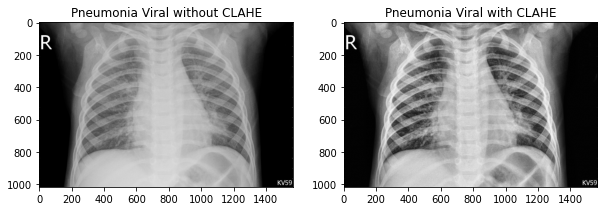

In [ ]:
#plot Pneumonia Viral image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia Viral without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Viral/person1080_virus_1791.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia Viral with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Viral/person1080_virus_1791.jpeg'))/255)
plt.show()

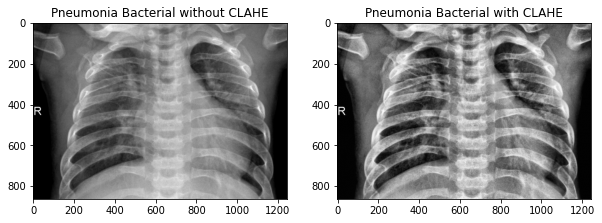

In [ ]:
#plot Pneumonia Bacterial image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia Bacterial without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Bacterial/person1001_bacteria_2932.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia Bacterial with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Bacterial/person1001_bacteria_2932.jpeg'))/255)
plt.show()

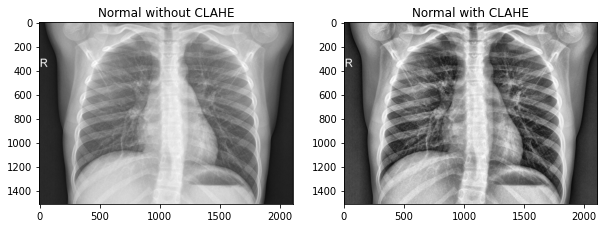

In [ ]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Normal without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Normal/IM-0003-0001.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Normal with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Normal/IM-0003-0001.jpeg'))/255)
plt.show()

# **Model**

In [ ]:
# data gens
with tf.device(device_name):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=10,
                                    shear_range = 20,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function = claheImage
                                    )

  test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.
  val_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.

  test_set = test_datagen.flow_from_directory(test_folder,
                                              target_size = (224, 224),
                                              class_mode = 'categorical',
                                              batch_size = 1,
                                              shuffle = False)

Found 442 images belonging to 3 classes.


In [ ]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [ ]:
# Freeze the % layers in the base model
percent = 0.32
number_of_layers_to_freeze =  int(number_of_layers * percent)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

In [ ]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(3, activation='softmax'))

In [ ]:
with tf.device(device_name):
  model.compile(
    optimizer="adamax",
    loss='categorical_crossentropy',
    metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_10 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                      



---
K-fold



In [ ]:
# Define the number of folds for cross-validation
num_folds = 10
# Define the cross-validation method
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
# Initialize lists to store the training and validation metrics for each fold
train_losses, train_accs, val_losses, val_accs = [], [], [], []

In [ ]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [ ]:
with tf.device(device_name):
  class_weight = {0: 2,1:1,2:5}

In [ ]:
# Loop over the folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
    # Print the fold number
    print('Fold', fold+1)
    
    training_set = train_datagen.flow_from_dataframe(
            train_df.iloc[train_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 64,
            class_mode = 'categorical')
    
    validation_set = val_datagen.flow_from_dataframe(
            train_df.iloc[val_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 64,
            class_mode = 'categorical')

    # Train the model on the training data for this fold
    history = model.fit(training_set, epochs=10, batch_size = 64,
                        steps_per_epoch=len(training_set),
                        validation_data=validation_set, 
                        validation_steps=len(validation_set), 
                        callbacks=[early_stopping, plateau,checkpoint],
                      class_weight = class_weight )
    
    # Get the training and validation metrics for this fold from the history object
    train_loss = history.history['loss'][-1]
    train_acc = history.history['acc'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_acc'][-1]
    
    # Append the training and validation metrics to the respective lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print the training and validation metrics for this fold
    print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
   

Fold 1
Found 7137 validated image filenames belonging to 3 classes.
Found 794 validated image filenames belonging to 3 classes.
Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 12.7103 - acc: 0.6710
Epoch 1: val_loss improved from inf to 10.91140, saving model to /content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/best_model.h5
112/112 [==============================] - 343s 3s/step - loss: 12.7103 - acc: 0.6710 - val_loss: 10.9114 - val_acc: 0.5957 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 10.6290 - acc: 0.7406
Epoch 2: val_loss improved from 10.91140 to 9.58135, saving model to /content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/best_model.h5
112/112 [==============================] - 224s 2s/step - loss: 10.6290 - acc: 0.7406 - val_loss: 9.5814 - val_acc: 0.6411 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 9.2348 - acc: 0.7

In [ ]:
# Compute the mean training and validation metrics across all folds
mean_train_loss = np.mean(train_losses)
mean_train_acc = np.mean(train_accs)
mean_val_loss = np.mean(val_losses)
mean_val_acc = np.mean(val_accs)

# Print the mean training and validation metrics
print("Mean Training Loss:", mean_train_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Validation Accuracy:", mean_val_acc)

In [ ]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)



*   Learning Curve (Loss)




In [ ]:
import seaborn as sns

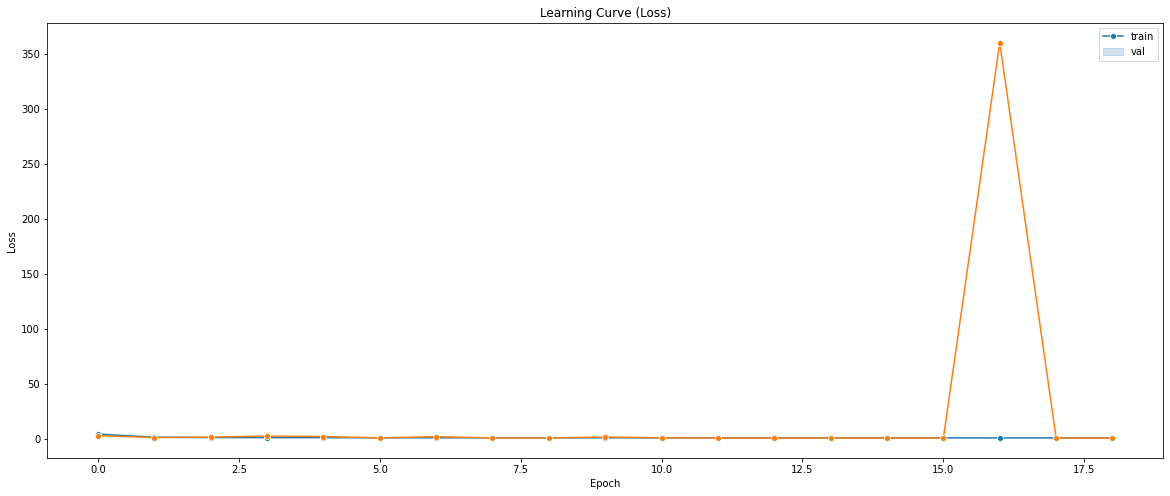

In [ ]:
# Learning Curve (Loss)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'],  marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_loss'], marker="o")
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/Learning Curve (Loss).png')
plt.show()

*   Learning Curve (Accuracy)

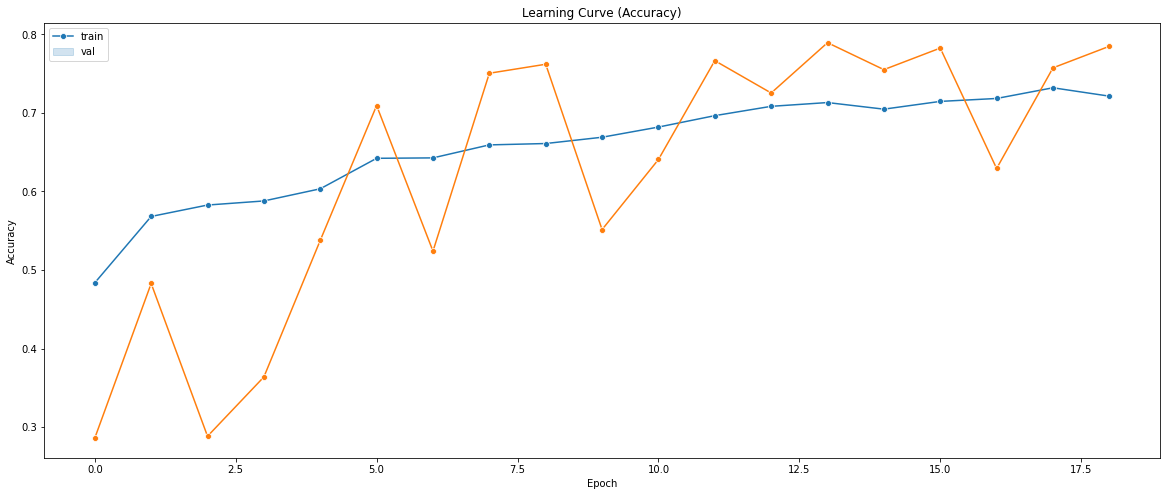

In [ ]:
# Learning Curve (Accuracy)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['acc'],marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_acc'],marker="o")
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/Learning Curve (Accuracy).png')
plt.show()

# **Performance Metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc

In [ ]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/best_model.h5')

In [ ]:
import pickle
# load the saved model from file
with open('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/history.pkl', 'rb') as file:
    hist = pickle.load(file)

# access the history attribute of the model
index_of_min = np.argmin(hist['val_loss']) # min val loss
loss = hist['loss'][index_of_min]
val_loss = hist['val_loss'][index_of_min]
acc = hist['acc'][index_of_min]
val_acc = hist['val_acc'][index_of_min]
print('---------------------best_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

index_last_epoch = len(hist['loss']) - 1 
loss = hist['loss'][index_last_epoch]
val_loss = hist['val_loss'][index_last_epoch]
acc = hist['acc'][index_last_epoch]
val_acc = hist['val_acc'][index_last_epoch]

print('---------------------last_epoch_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

---------------------best_model-----------------------
acc: 0.8726
loss: 0.8352
val_acc: 0.8467
val_loss: 0.4621
---------------------last_epoch_model-----------------------
acc: 0.8824
loss: 0.7461
val_acc: 0.8444
val_loss: 0.4813




*   Test evaluation



In [ ]:
# test evaluation
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)

442/442 [==============================] - 199s 445ms/step - loss: 0.5535 - acc: 0.8620
Test accuracy: 0.8619909286499023
Test loss: 0.5534754991531372




*   Confusion matrix



In [ ]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

442/442 [==============================] - 30s 66ms/step


In [ ]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

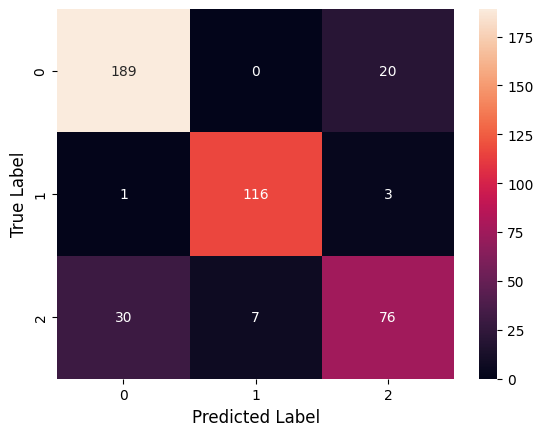

In [ ]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/K-fold cross validation try 1/confusion_matrix_res2.png')
plt.show()

*   sensitivity & specificity

In [ ]:
def calculate_sen_spe(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    return sensitivity, specificity

In [ ]:
sensitivity, specificity = calculate_sen_spe(test_set.classes, y_pred)
print('sensitivity: '+"{:0.4f}".format(sensitivity))
print('specificity: '+"{:0.4f}".format(specificity))



*   precision  -  recall - f1-score - support



In [ ]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1,2],digits=4))

              precision    recall  f1-score   support

           0     0.8468    0.8995    0.8724       209
           1     0.9826    0.9417    0.9617       120
           2     0.7524    0.6991    0.7248       113

    accuracy                         0.8597       442
   macro avg     0.8606    0.8468    0.8530       442
weighted avg     0.8596    0.8597    0.8589       442





*  ROC Curve



In [ ]:
# Select the second column to obtain the predicted probabilities of the positive class
# fpr -> false positive rate tpr-> true positive rate
fpr, tpr, thresholds = roc_curve(test_set.classes, Y_pred[:,1])

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)
print('ROC_AUC: ', roc_auc)

# plot the ROC curve
plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', label = 'ROC_AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/Vgg19 try/COURBE ROC avec AUC.png')
plt.show()

# **CAM**

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib

In [ ]:
# Find the last convolutional layer
layer = model.get_layer('mobilenet_1.00_224')

In [ ]:
img_ori = claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Viral/person1089_virus_1808.jpeg'))/255
img = cv2.resize(img_ori, (224,224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
#/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia/person1393_virus_2396.jpeg

In [ ]:
preds = model.predict(x)
predicted_class = np.argmax(preds)
print(predicted_class)

1/1 [==============================] - 0s 62ms/step
2


1/1 [==============================] - 1s 515ms/step


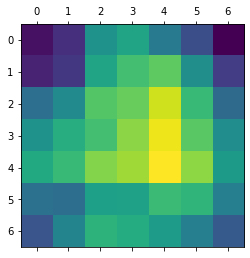

In [ ]:
from google.colab.patches import cv2_imshow
new_model = tf.keras.models.Model(inputs=layer.input, outputs=[layer.get_layer('conv_pw_13').output])
# Get the final convolutional feature maps for the input image
conv_outputs = new_model.predict(x)
# Compute the class activation map
class_weights = model.layers[-1].get_weights()[0][:,predicted_class]
arr = np.ones((512,))
class_weights = np.concatenate((arr,class_weights ))
# Compute the class activation map
cam1 = np.dot(conv_outputs, class_weights)
res =cam1[0, :, :]
# Plot the class activation map
plt.matshow(cam1[0, :, :], cmap='viridis')
plt.show()

In [ ]:
def superimpose_gradcam(img,heatmap, alpha=0.7):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = matplotlib.colormaps.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)/255
    plt.imshow(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

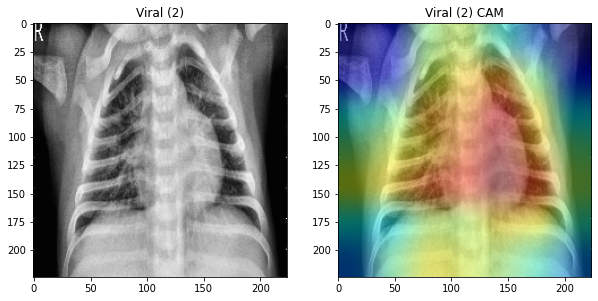

In [ ]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Viral (2)')
plt.imshow(img)

fig.add_subplot(rows, columns, 2)
plt.title('Viral (2) CAM')
plt.imshow(superimpose_gradcam(img, res))
plt.show()